# 1D Regression

Basic demonstration of GPs for regression

In [1]:
import os, sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from gptorch.models.gpr import GPR
from gptorch.models.sparse_gpr import VFE
from gptorch import kernels
from gptorch.util import TensorType
from gptorch import mean_functions

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
def f(x):
    return np.sin(2. * np.pi * x) + np.cos(3.5 * np.pi * x) - 3.0 * x

n = 100
x = np.linspace(0, 1, n).reshape((-1, 1))
y = f(x) + 0.1 * np.random.randn(n, 1)

## Kernel

An exponentiated quadratic (aka "Gaussian"/"RBF") kernel is the usual, but feel free to try other kernels, or combinations.

In [4]:
kern = kernels.Rbf(1)
# kern = kernels.Matern32(1)
# kern = kernels.Matern52(1)
# kern = kernels.Exp(1)
# kern = kernels.Constant(1)
# kern = kernels.Linear(1)
# kern = kernels.Sum(kernels.Linear(1), kernels.Rbf(1))

## Model

Try either a full or sparse GP

In [5]:
model = GPR(y, x, kern)
# model = VFE(y, x, kern)

In [6]:
# This problem is simple, but it's generally a good idea to make the likelihood 
# varince small so that we don't explain the data as noise.
# Right now, .data accesses the unconstrained value, so we need to apply "log"
# (or whatever inverse transform is appropriate) ourselves.
model.likelihood.variance.data = TensorType([np.log(1.0e-6)])

## Train

In [7]:
model.optimize(method="L-BFGS-B", max_iter=100)
print("Trained model:\n{}".format(model))

Scipy.optimize.minimize...
loss: [3690142.78098492]
loss: [286725.60184212]
loss: [278197.90598228]
loss: [246595.57291961]
loss: [99382.45407251]
loss: [54003.19057498]
loss: [26076.15399733]
loss: [13077.13168697]
loss: [6367.10768486]
loss: [3060.1025926]
loss: [1415.70816208]
loss: [613.47938756]
loss: [229.90594634]
loss: [51.73064922]
loss: [-26.72811008]
loss: [-57.59142957]
loss: [-66.913107]
loss: [-68.47263419]
loss: [-68.78822426]
loss: [-69.08809952]
loss: [-69.69527936]
loss: [-70.18379729]
loss: [-70.26258841]
loss: [-70.26629434]
loss: [-70.26656226]
loss: [-70.26656908]
loss: [-70.26656914]
Trained model:
gpr (
  (kernel): Rbf (
  variance
  tensor([5.1447], dtype=torch.float64)
  length_scales
  tensor([0.2339], dtype=torch.float64)
  )
  
  (likelihood): Gaussian (
  variance
  tensor([0.0083], dtype=torch.float64)
  )
  
)



## Predict

We'll look at the mean, 95% (2 std deviation) confidence interval, and a few samples from the posterior.

In [8]:
n_test = 200
n_samples = 5
x_test = np.linspace(-1, 2, n_test).reshape((-1, 1))
mu, s = model.predict_y(x_test)
mu, s = mu.detach().numpy().flatten(), s.detach().numpy().flatten()
y_samp = model.predict_y_samples(x_test, n_samples).detach().numpy()
unc = 2.0 * np.sqrt(s)

And visualize the results...

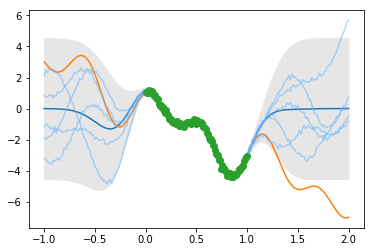

In [9]:
 x_test = x_test.flatten()
plt.figure()
plt.fill_between(x_test, mu - unc, mu + unc, color=(0.9,) * 3)
plt.plot(x_test, mu)
plt.plot(x_test, f(x_test))
for y_samp_i in y_samp:
    plt.plot(x_test, y_samp_i, color=(0.4, 0.7, 1.0), alpha=0.5)
plt.plot(x, y, 'o')
plt.show()